1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями
2. Добавьте первые разности по стоимости доллара и евро к рублю (можно добавить и сами курсы валют - прошлые значения)
3. сделайте ее перрасчет (ресемплинг) в представление по неделям.
4. Постройте модель предсказания 1-й точки от текущей (h=1).
5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true[y_true==0] = 1
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
data = pd.read_csv('my_BRENT2019.csv', index_col=[0], parse_dates=[0])

In [4]:
dol = pd.read_excel('RC_F01_09_2010_T01_09_2019.xlsx', index_col=[1], parse_dates=[1])
eur = pd.read_excel('R_E01_09_2010_T01_09_2019.xlsx', index_col=[1], parse_dates=[1])

In [5]:
data['dol']=dol['curs']
data['eur']=eur['curs']

In [6]:
data = data.iloc[:, np.r_[0, 11:13]].rename({'Значение':'oil'}, axis=1)

In [7]:
data['d_oil'] = 0
data.iloc[1:,3] = data['oil'].values[1:] - data['oil'].values[:-1]
data['d_dol'] = 0
data.iloc[1:,4] = data['dol'].values[1:] - data['dol'].values[:-1]
data['d_eur'] = 0
data.iloc[1:,5] = data['eur'].values[1:] - data['eur'].values[:-1]

In [8]:
data = data.resample('w').mean()

In [9]:
data = data.fillna(0)

In [10]:
model_g = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)

In [11]:
h = 1
target = data['oil'].values[h:]
X_data_full = data.iloc[:-h,[0, 3, 4, 5]].values
X_data_only = data.iloc[:-h,[0, 3]].values

In [12]:
model_g.fit( X_data_full[:369], target[:369] )
y_pred_full = model_g.predict(X_data_full[369:])

In [13]:
model_g.fit( X_data_only[:369], target[:369] )
y_pred_only = model_g.predict(X_data_only[369:])

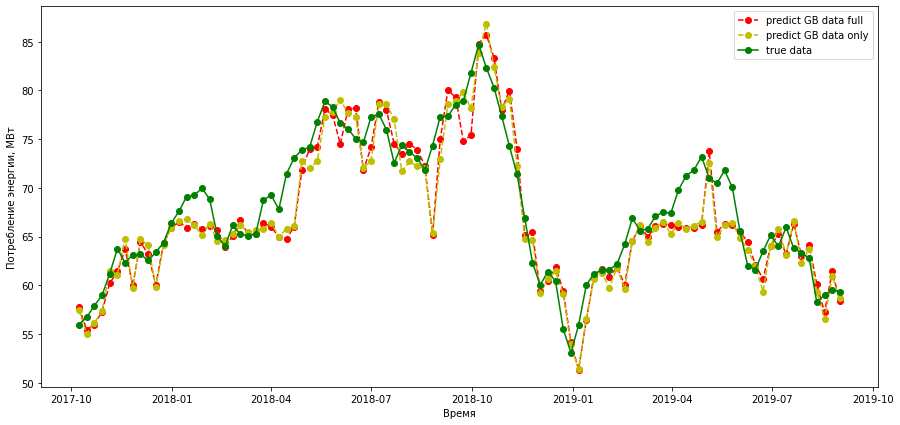

In [14]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(data.index[370:], y_pred_full, '--or', label='predict GB data full' )
plt.plot(data.index[370:], y_pred_only, '--oy', label='predict GB data only' )
plt.plot(data.index[370:], target[369:], '-og', label='true data')

plt.legend()
plt.show()

In [15]:
er_g = mean_absolute_percentage_error(target[369:], y_pred_full)

print('ошибка градиентного бустинга MAPE with currency:  ', er_g,'%')

ошибка градиентного бустинга MAPE with currency:   3.2464397913998506 %


In [16]:
er_g = mean_absolute_percentage_error(target[369:], y_pred_only )

print('ошибка градиентного бустинга MAPE only Brent:  ', er_g,'%')

ошибка градиентного бустинга MAPE only Brent:   3.311625178361419 %


#### Первые разности по валютам незначительно улучшают качество прогноза